In [1]:
import copy
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import models
from posteriors.swag import SWAG
import utils

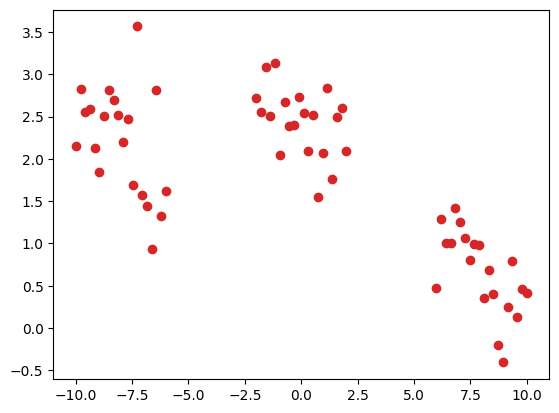

In [3]:
def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)

arr = np.load('data.npz') 
x = torch.from_numpy(arr['x'])
f = featurize(x)
y = torch.from_numpy(arr['y']) * 10

x_ = torch.from_numpy(arr['x_'])
f_ = featurize(x_)
y_ = torch.from_numpy(arr['y_']) * 10

plt.scatter(x, y, color='#D62728')
plt.show()

In [4]:
def prior(model, prior_var):
    loss = 0.0
    for p in model.parameters():
        loss += torch.norm(p)**2 / (2 * prior_var)
    return loss

model = models.Regressor()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.functional.mse_loss
noise_var = 0.0005
prior_var = 100

swag_model = SWAG(model)
swag_start = 18_000
swag_frequency = 100

losses = []

for epoch in range(20_000):
    if epoch > swag_start: utils.adjust_learning_rate(optimizer, 5e-2)
    optimizer.zero_grad()
    preds = model(f)
    loss = criterion(preds, y) / (2 * noise_var)
    loss += prior(model, prior_var) / len(y) 
    losses.append(loss.item())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    if epoch > swag_start and epoch % swag_frequency == 0:
        swag_model.collect_model(model)

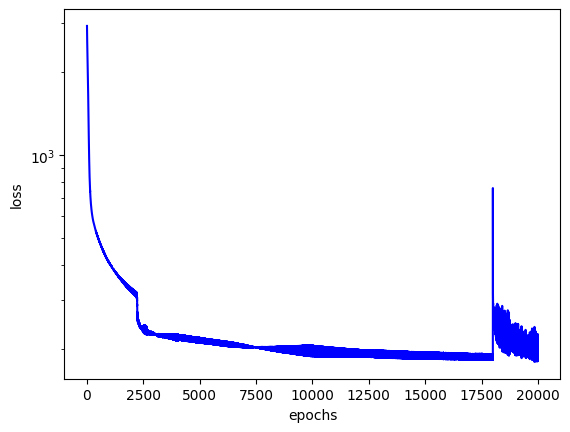

In [5]:
plt.plot(range(len(losses)), losses, '-b')
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [6]:
swag_all_preds = []

for _ in range(100):
    sampled_params = swag_model.sample()
    torch.nn.utils.vector_to_parameters(sampled_params, model.parameters())
    preds = model(f_).data.numpy()[None, :]
    swag_all_preds.append(preds.copy())

swag_all_preds = np.vstack(swag_all_preds)
np.save("swag_preds", swag_all_preds)

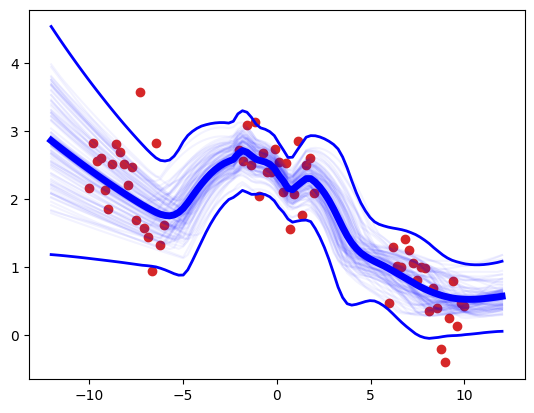

In [7]:
all_preds = np.load('swag_preds.npy')[:]
pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + 3*pred_std
pred_lower = pred_mean - 3*pred_std

plt.scatter(x, y, color='#D62728')
plt.plot(x_.data.numpy(), all_preds[:, :, 0].T, '-b', alpha=0.05);
plt.plot(x_.data.numpy(), pred_mean, '-b', lw=5)
plt.plot(x_.data.numpy(), pred_lower, '-b', lw=2)
plt.plot(x_.data.numpy(), pred_upper, '-b', lw=2)
plt.show()

In [8]:
de_all_preds = []

for _ in tqdm(range(100)):
    model = models.Regressor()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    criterion = torch.nn.functional.mse_loss
    noise_var = 0.0005
    prior_var = 100
    
    for epoch in range(20_000):
        optimizer.zero_grad()
        preds = model(f)
        loss = criterion(preds, y) / (2 * noise_var)
        loss += prior(model, prior_var) / len(y) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    preds = model(f_).data.numpy()[None, :]
    de_all_preds.append(preds.copy())
    
de_all_preds = np.vstack(de_all_preds)
np.save("deep_ensembles_preds", de_all_preds)

100%|██████████| 100/100 [22:01<00:00, 13.22s/it]


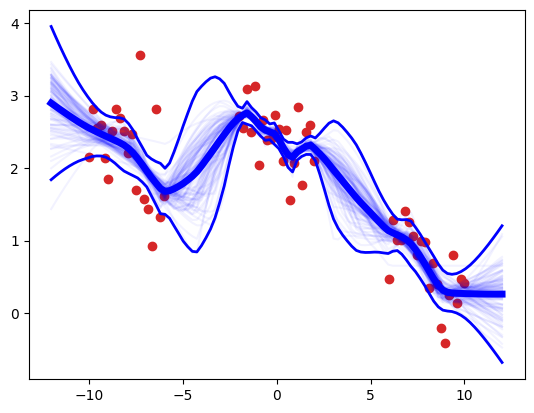

In [9]:
all_preds = np.load('deep_ensembles_preds.npy')[:]
pred_mean = all_preds.mean(axis=0)
pred_std = all_preds.std(axis=0)
pred_upper = pred_mean + 3*pred_std
pred_lower = pred_mean - 3*pred_std

plt.scatter(x, y, color='#D62728')
plt.plot(x_.data.numpy(), all_preds[:, :, 0].T, '-b', alpha=0.05);
plt.plot(x_.data.numpy(), pred_mean, '-b', lw=5)
plt.plot(x_.data.numpy(), pred_lower, '-b', lw=2)
plt.plot(x_.data.numpy(), pred_upper, '-b', lw=2)
plt.show()